This code was written by Zainab Haider

Jupyter Notebook/Python

08/30/2020

# **Predicting Progression of Pulmonary Fibrosis using Multiple Linear Regression**

In this notebook, I have used Multiple Linear Regression to predict lung capacity decline in Pulmonary Fibrosis patients.

The dataset for this project is from the OSIC Pulmonary Fibrosis Progression project on Kaggle: https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression, which looks at lung capacity over time for patients with pulmonary fibrosis.

# **Library**

In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

# **Load Data**

In [2]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
sample = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

In [3]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


# **Exploratory Data Analysis**

There is no missing data or any duplicate data in this dataset.


There are 1549 entries in this dataset, with 7 columns:
* *Patient* - Patient ID; There are 176 unique patient IDs in this dataset.
* *Weeks* - This is the number of weeks since the baseline CT scan (Week 0). The data for number of weeks ranges from -5 to 133, where negative values for Weeks are the number of weeks before the baseline data was collected
* *FVC* - Forced Vital Capacity, measured in mililiters (mL). This is a measure of the maximal exhalation of air from the lungs. 
* *Percent* - According to OSIC's definition, this is a measure of a patient's FVC as a percent of the FVC of a person with similar characteristics. In other words: it is a measure how a patient's lung capacity compares to similar patients. Ranges from 28% to 153% for patients in this dataset.
* *Age* - Age of patients. Ranges from 49 to 88.
* *Sex* - 37 females (21.02% of patients), 139 males (78.98% of patients)
* *Smoking Status* - 9 currently smoke (5.11% of patients), 118 are ex-smokers (67.05% of patients), and 49 are non-smokers (27.84% of patients)

In [4]:
print(train.shape)
missing = (train.isnull().sum())
print(missing[missing > 0])
print("No missing data")

(1549, 7)
Series([], dtype: int64)
No missing data


In [5]:
dups = train.duplicated()
if dups.any() == False:
    print("No duplicate data")

No duplicate data


In [6]:
print("Total number of data points: " + str(train['Patient'].count()))
print("Total number of patients: " + str(train['Patient'].nunique()))

Total number of data points: 1549
Total number of patients: 176


Minimum number of weeks: -5
Maximum number of weeks: 133


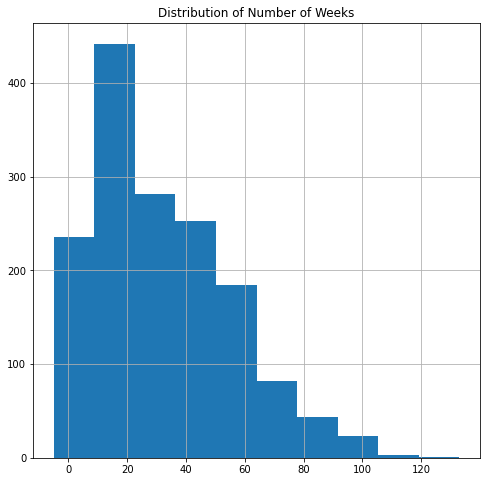

In [7]:
# Weeks Data

print("Minimum number of weeks: " + str(train['Weeks'].min()))
print("Maximum number of weeks: " + str(train['Weeks'].max()))

plt.title('Distribution of Number of Weeks')
train['Weeks'].hist(bins=10, figsize=(8, 8))

Minimum value for Percent: 28.877576671694303
Maximum value for Percent: 153.145377828922


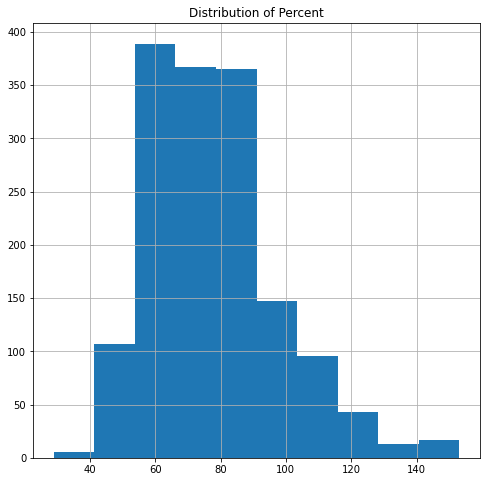

In [8]:
# Percent Data

print("Minimum value for Percent: " + str(train['Percent'].min()))
print("Maximum value for Percent: " + str(train['Percent'].max()))

plt.title('Distribution of Percent')
train['Percent'].hist(bins=10, figsize=(8, 8))

From the scatterplot of number of weeks and FVC measurements (below), we can see that majority of patients had FVC measurements below 5000 mL. An FVC measurement of 4800 mL, or greater, is considered healthy. Since patients with pulmonary fibrosis are characterized to have compromised lung function, the FVC measurements are expected to be below 4800 mL. 

However, there are a few outliers that have very high FVC values. After some investigation, I found that nearly all the FVC values greater than 5000 mL came from one patient: ID00219637202258203123958. One of the FVC values for this patient is above 6000 mL, which seems to be the largest outlier so far. After analyzing factors such as age and smoking status, I will decide if this outlier should be removed from the dataset.

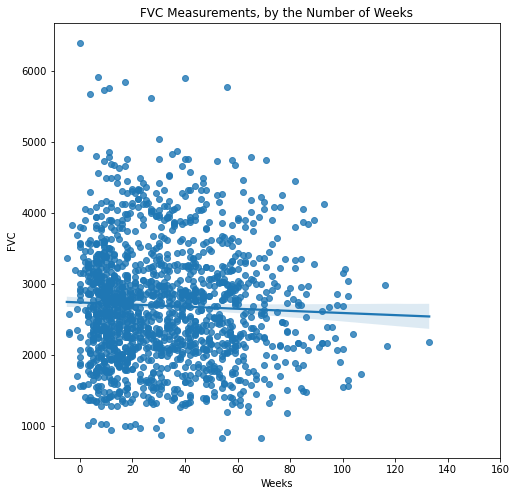

In [9]:
# FVC x Weeks

plt.figure(figsize=(8,8))
plt.xlim(-10, 160)
plt.title('FVC Measurements, by the Number of Weeks')
sns.regplot(x=train['Weeks'], y=train['FVC'])


In [10]:
# Subset of patients that have FVC measurements greater than 5000 mL
# As you can see, 9 out of the 10 entries are associated with patient ID00032637202181710233084, where the baseline FVC measurement is above 6000 mL.
train.loc[train.FVC > 5000]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
124,ID00032637202181710233084,30,5045,119.629138,63,Male,Ex-smoker
822,ID00219637202258203123958,0,6399,153.012912,71,Male,Ex-smoker
823,ID00219637202258203123958,4,5678,135.772358,71,Male,Ex-smoker
824,ID00219637202258203123958,7,5910,141.319943,71,Male,Ex-smoker
825,ID00219637202258203123958,9,5739,137.230990,71,Male,Ex-smoker
826,ID00219637202258203123958,11,5763,137.804878,71,Male,Ex-smoker
827,ID00219637202258203123958,17,5844,139.741750,71,Male,Ex-smoker
828,ID00219637202258203123958,27,5613,134.218077,71,Male,Ex-smoker
829,ID00219637202258203123958,40,5895,140.961263,71,Male,Ex-smoker
830,ID00219637202258203123958,56,5768,137.924438,71,Male,Ex-smoker


I created a 'fvcstat' dataset to look at the Age, Sex, SmokingStatus variables for the individual patients, rather than every data point. These three variables are constant and remain unchanged, so it is more meaninful to analyze this data by patient. 

Thus, this dataset has 176 entries, rather than 1549. This way, the histogram plot is not biased by the presence of more data points available for a particular patient. For example, if a dataset included data for a non-smoker patient with 10 entries and an ex-smoker patient with 2 entries, then a histogram would show that there is a higher frequency of non-smoker patients than ex-smokers, which is not true.

Further, to analyze FVC values based on age, sex, and smoking status, I decided to analyze the median FVC value for each patient, rather than the individual FVC values. Similar to the problem of having more data points for one patient over the other, analyzing FVC valus based on age and smoking status can be skewed when one patient's data points, or one age group, or one smoking status exists more than the other. To counter this, I am analyzing each patient's data with the median FVC value. There is some loss of precision here, because many patients have data that fluctuates dramatically, but the data is no longer skewed because one factor has more data available than another.

In [11]:
fvcstat = train.groupby(['Patient','Age','Sex','SmokingStatus']).FVC.agg([min, max,'mean','median'])
fvcstat = fvcstat.reset_index()

Minimum value for Age: 49
Maximum value for Age: 88


Text(0.5, 1.0, 'Distribution of Age')

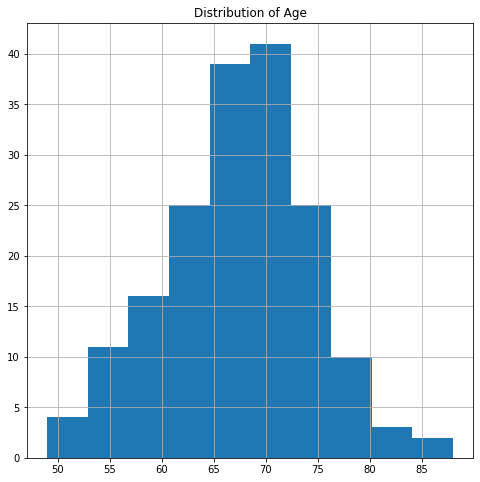

In [12]:
# Age Data

print("Minimum value for Age: " + str(fvcstat['Age'].min()))
print("Maximum value for Age: " + str(fvcstat['Age'].max()))

fvcstat['Age'].hist(bins=10, figsize=(8, 8))
plt.title('Distribution of Age')

This dataset consists of significantly more male patients than female patients, which can add a sex bias to data analysis and the model. Ekstrom et al. (2014) explained that, a majority of patients with idiopathic pulmonary fibrosis (IPF), the most common form of pulmonary fibrosis (PF), are male, with a "history of current or past smoking." So, although there seems to be a sex bias, its possible that this is representative of the population of individuals with PF.

      Sex  count
0  Female     37
1    Male    139


<Figure size 576x576 with 0 Axes>

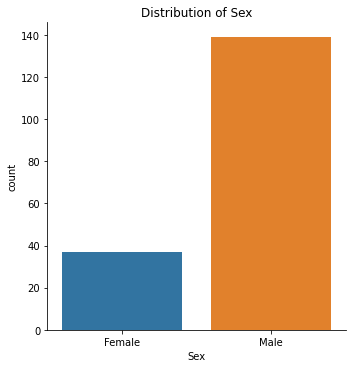

<Figure size 576x576 with 0 Axes>

In [13]:
# Sex Data

sex = fvcstat.groupby(['Sex'])['Sex'].agg(['count']).reset_index()
print(sex)

sns.catplot(x="Sex", y="count", kind="bar", data=sex)
plt.title('Distribution of Sex')
plt.figure(figsize=(8,8))


The age distributions for both males and females follow a similar shape, where both distributions has increased frequency of patients between the ages 60-65, and lower frequency of patients under 60 and greater then 75.

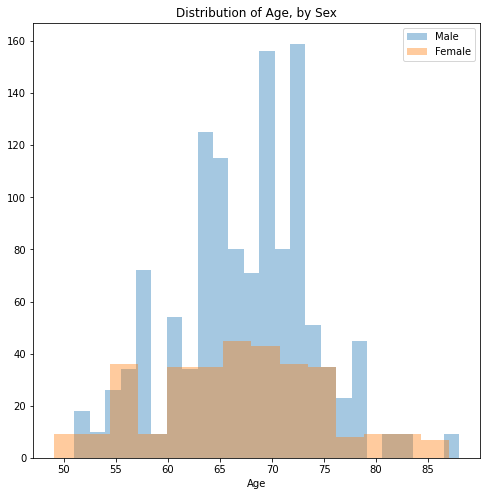

In [14]:
# Age distribution, by sex

plt.figure(figsize=(8,8))

m = train.loc[train.Sex == 'Male']
fm = train.loc[train.Sex == 'Female']

# Histograms for each sex
sns.distplot(a=m['Age'], label="Male", kde=False)
sns.distplot(a=fm['Age'], label="Female", kde=False)

plt.title("Distribution of Age, by Sex")

plt.legend()

The plot below shows that, in this dataset, female patients have a much lower median FVC than their male counterparts. Median FVC values for female patients hovers 2000 mL, whereas median FVC values for male patients is around 3000 mL.

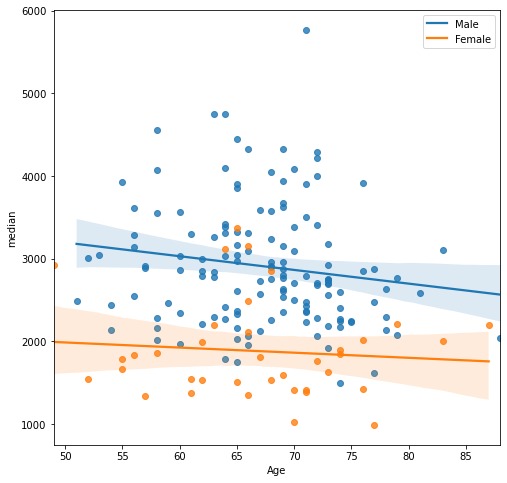

In [15]:
# Need to see the relationship between median FVC x Age, with regards to sex
plt.figure(figsize=(8,8))

f = fvcstat.loc[fvcstat.Sex == 'Male'] 
sns.regplot(x=f['Age'], y=f['median'])

g = fvcstat.loc[fvcstat.Sex == 'Female'] 
sns.regplot(x=g['Age'], y=g['median'])

plt.legend(labels=['Male', 'Female'])

There is a difference in the smoking status of males and females. For females patients, 32.43% are ex-smokers and 62.16% are non-smokers, whereas 66.67% of the male patients are ex-smokers and 18.71% are non-smokers. This seems to match the research on smoking status of patients with PF. Research by Kärkkäinen et al. (2017) showed that majority of non-smoker patients were female. In this dataset, non-smoker females and males are split equally (47% and 53%, respectively), but the majority of female patients were non-smokers.

      SmokingStatus  count
0  Currently smokes      9
1         Ex-smoker    118
2      Never smoked     49

      Sex     SmokingStatus  count
0  Female  Currently smokes      2
1  Female         Ex-smoker     12
2  Female      Never smoked     23
3    Male  Currently smokes      7
4    Male         Ex-smoker    106
5    Male      Never smoked     26


<Figure size 576x576 with 0 Axes>

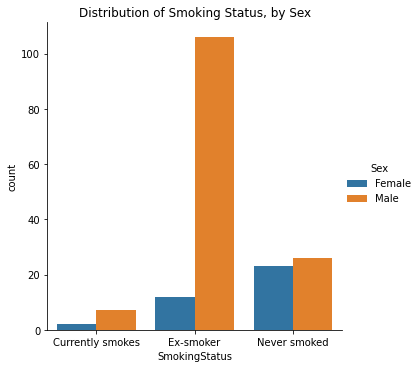

<Figure size 576x576 with 0 Axes>

In [16]:
# Smoking Data

smoking = fvcstat.groupby(['SmokingStatus'])['SmokingStatus'].agg(['count']).reset_index()
smoking_sex = fvcstat.groupby(['Sex','SmokingStatus'])['Sex'].agg(['count']).reset_index()

print(smoking); print('')
print(smoking_sex)

sns.catplot(x="SmokingStatus", y="count", hue="Sex",kind="bar", data=smoking_sex)
plt.title('Distribution of Smoking Status, by Sex')
plt.figure(figsize=(8,8))

From the plot below, we see that the median FVC values decrease as age increases for individuals with a history of smoking. However, for non-smokers median FVC values actually seem to increase as age increases. It's not a dramatic increase, but it is still odd. According to the American Lung Association, FVC can decrease by 200 mL each decade, including "healthy people who have never smoked." This could be attributed to the sample size of non-smokers.

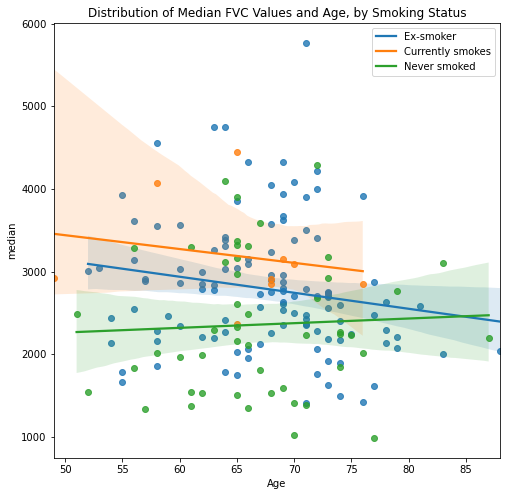

In [17]:
# age x smoking status by smoking
plt.figure(figsize=(8,8))
plt.title('Distribution of Median FVC Values and Age, by Smoking Status')

f = fvcstat.loc[fvcstat.SmokingStatus == 'Ex-smoker'] 
sns.regplot(x=f['Age'], y=f['median'])

g = fvcstat.loc[fvcstat.SmokingStatus == 'Currently smokes'] 
sns.regplot(x=g['Age'], y=g['median'])

h = fvcstat.loc[fvcstat.SmokingStatus == 'Never smoked'] 
sns.regplot(x=h['Age'], y=h['median'])

plt.legend(labels=['Ex-smoker', 'Currently smokes', 'Never smoked'])

Data for the Distribution of Percent and FVC values has a stronger correlation for male patients than female patients but that can likely be attributed to the fact that more data is available for male patients. In this dataset, the variable 'Percent' described how the FVC values for a patient compares to the FVC values of someone with similar characteristics (like, co-morbodities). So, it follows that Percent and FVC values are correlated

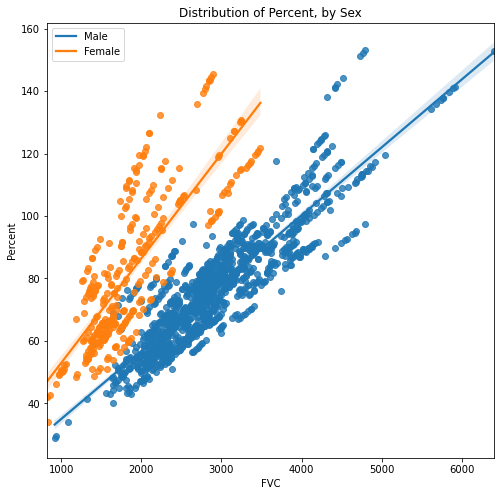

In [18]:
# Need to see the relationship between FVC x Percent, with regards to sex
plt.figure(figsize=(8,8))

f = train.loc[train.Sex == 'Male'] 
sns.regplot(x=f['FVC'], y=f['Percent'])

g = train.loc[train.Sex == 'Female'] 
sns.regplot(x=g['FVC'], y=g['Percent'])

plt.title("Distribution of Percent, by Sex")

plt.legend(labels=['Male', 'Female'])

# **Data Cleaning**

I will be removing the data for Patient ID00219637202258203123958 because that data is a major outlier. This patient is a 71-year old ex-smoker male with high FVC values (greater than 5000 mL) and high Percent values (greater than 130%). An FVC measurement of 4800 mL, or greater, is considered a normal measurement. Further, according to the American Lung Association, total lung capacity is approximately 6000 mL. Thus, it seems anomalous to have a patient of pulmonary fibrosis, with a history of smoking, to have FVC measurements close to 6000 mL. For this reason, I am omitting this patient from the dataset.

In [19]:
# Remove Patient ID00219...3958 

train = train[train.Patient != 'ID00219637202258203123958']

The Sex and Smoking Status data is categorical data, so I converted it into encoded it into numerical data. So, there will be one column for Sex, where 1 is Male and 0 is Female. And there will be a Non-smoker column, where 1 is a non-smoker, with no history of smoking, and 0 indicated a history of smoking.

In [20]:
# One-hot Encode Sex and SmokingStatus columns in train data set

from sklearn.preprocessing import OneHotEncoder
exp_train = train
obj_col = ['Sex','SmokingStatus']

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(exp_train[obj_col]))

# One-hot encoding removed index; put it back
OH_cols_train.index = exp_train.index

# Adds names to each new column
OH_cols_train.columns = OH_encoder.get_feature_names(obj_col)

# Remove categorical columns (will replace with one-hot encoding)
num_train = exp_train.drop(obj_col, axis=1)

OH_train = pd.concat([num_train, OH_cols_train], axis=1)

# Drop these columns. Not using this data
OH_train = OH_train.drop(['SmokingStatus_Ex-smoker'], axis=1)
OH_train = OH_train.drop(['SmokingStatus_Currently smokes'], axis=1)
OH_train = OH_train.drop(['Sex_Female'], axis=1)

# Rename columns
OH_train.rename(columns = {'Sex_Male':'Sex'}, inplace = True) # 1 is Male, 0 is Female
OH_train.rename(columns = {'SmokingStatus_Never smoked':'Non-smoker'}, inplace = True) # 1 is Non-smoker, 0 is History of smoking



# One-hot Encode Sex and SmokingStatus columns in test data set

exp_test = test

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(exp_test[obj_col]))

# One-hot encoding removed index; put it back
OH_cols_test.index = exp_test.index

# Adds names to each new column
OH_cols_test.columns = OH_encoder.get_feature_names(obj_col)

# Remove categorical columns (will replace with one-hot encoding)
num_test = exp_test.drop(obj_col, axis=1)

OH_test = pd.concat([num_test, OH_cols_test], axis=1)

OH_test = OH_test.drop(['SmokingStatus_Ex-smoker'], axis=1) #not using this
OH_test.rename(columns = {'Sex_Male':'Sex'}, inplace = True) # 1 is Male, 0 is Female
OH_test.rename(columns = {'SmokingStatus_Never smoked':'Non-smoker'}, inplace = True) # 1 is Non-smoker, 0 is History of smoking

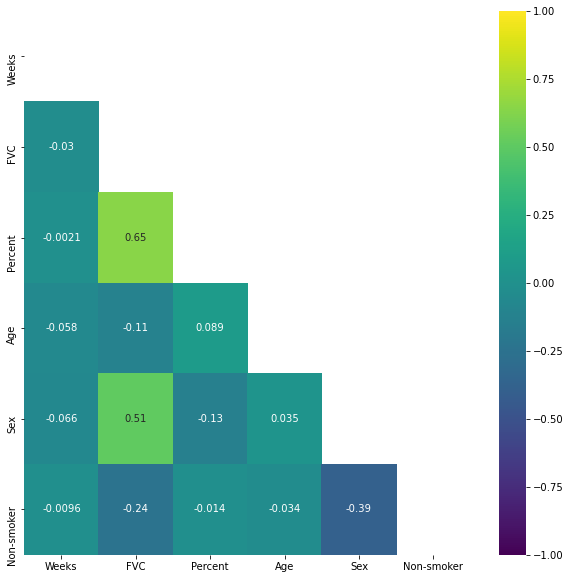

In [21]:
# Heatmap - checking for correlation

mask = np.zeros_like(OH_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,10))
sns.heatmap(OH_train.corr(),vmin=-1,cmap = 'viridis',annot=True,mask = mask)

# **Multiple Linear Regression Model**

First, I am splitting the Patient_Week column in the sample submission ('sample') dataset to Patient and Week, because that is the format used in the training and test data. 
Next, I will merge the test and sample data together. The test dataset contains all data for 5 patients. The sample dataset contains data for Patient ID and Week Number for the 5 patients in the test dataset. In this project, I will be predicting FVC by Weeks,Age, Percent, Sex, and Smoking Status for patients in the sample dataset. I will be importing information about Age, Percent, Sex, and Smoking Status from the test dataset my merging the two datasets.

In [22]:
sample['Weeks']   = sample['Patient_Week'].apply( lambda x: int(x.split('_')[-1]) )
sample['Patient'] = sample['Patient_Week'].apply( lambda x: x.split('_')[0] )
sample = sample[['Patient','Weeks','Confidence','Patient_Week']]
OH_test = OH_test.drop(['Weeks'], axis=1)
sub = sample.merge(OH_test, on="Patient")

Training the model:

In [23]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# features
X = OH_train[['Weeks','Age','Percent','Sex','Non-smoker']].values
y = OH_train['FVC'].values

#train the Regression Model
regressionmodel = LinearRegression()  
regressionmodel.fit(X, y)
OH_train['y_pred'] = regressionmodel.predict(X)

I wanted to evaluate this model using metrics for regression models: MAE, MSE, and RMSE.

RMSE (Root Mean Squared Error) is a widely accepted evaluation metric for regression models, so I want to focus on this value to evaluate my model's predictions. The code below shows that the RMSE is 12.39% of the mean FVC value. Although a 12% error is not ideal, it suggests that the model is able to predict FVC values close to the actual measurements. 

I will be using this model to predict FVC values in the sample submission dataset, which will be submitted to the OSIC competition on Kaggle.

In [24]:
meanfvc = np.mean(OH_train['FVC'].values)
rmseval = np.sqrt(metrics.mean_squared_error(OH_train['FVC'].values, OH_train['y_pred'].values))

print('Mean Absolute Error:', metrics.mean_absolute_error(OH_train['FVC'].values, OH_train['y_pred'].values))  
print('Mean Squared Error:', metrics.mean_squared_error(OH_train['FVC'].values, OH_train['y_pred'].values))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(OH_train['FVC'].values, OH_train['y_pred'].values)))
print('Mean of Actual FVC Values:', np.mean(OH_train['FVC'].values))
print('Root Mean Squared Error is',round(rmseval/meanfvc*100.00,2),'% of the Mean of FVC Values')

Mean Absolute Error: 257.2392485551861
Mean Squared Error: 109647.32039531477
Root Mean Squared Error: 331.13036767308853
Mean of Actual FVC Values: 2672.0409090909093
Root Mean Squared Error is 12.39 % of the Mean of FVC Values


Now that I have trained the model, I will use the regression model (regressionmodel) to predict FVC values for the patients in the submission (sub) dataset:

In [25]:
sub.sort_values( ['Patient','Weeks'], inplace=True )

X2 = sub[['Weeks','Age','Percent','Sex','Non-smoker']].values
            
sub['FVC'] = regressionmodel.predict(X2)
sub['Confidence'] = np.std(sub['FVC'])
sub

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,Non-smoker
0,ID00419637202311204720264,-12,171.984196,ID00419637202311204720264_-12,2571.950674,70.186855,73,1.0,0.0
1,ID00419637202311204720264,-11,171.984196,ID00419637202311204720264_-11,2571.995761,70.186855,73,1.0,0.0
2,ID00419637202311204720264,-10,171.984196,ID00419637202311204720264_-10,2572.040848,70.186855,73,1.0,0.0
3,ID00419637202311204720264,-9,171.984196,ID00419637202311204720264_-9,2572.085935,70.186855,73,1.0,0.0
4,ID00419637202311204720264,-8,171.984196,ID00419637202311204720264_-8,2572.131023,70.186855,73,1.0,0.0
...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,171.984196,ID00426637202313170790466_129,2642.564065,71.824968,73,1.0,1.0
726,ID00426637202313170790466,130,171.984196,ID00426637202313170790466_130,2642.609152,71.824968,73,1.0,1.0
727,ID00426637202313170790466,131,171.984196,ID00426637202313170790466_131,2642.654239,71.824968,73,1.0,1.0
728,ID00426637202313170790466,132,171.984196,ID00426637202313170790466_132,2642.699326,71.824968,73,1.0,1.0


The function below is not my own. This function definition for the Laplace Log Likelihood metric is taken from https://www.kaggle.com/rohanrao/osic-understanding-laplace-log-likelihood

This is the metric that the OSIC Competition is using to evaluate models. In my case, I am using it to approximate how useful my model is before submitting. According to the article linked above, -8.023 is the minimum score needed for a model to be considered useful, and my approximation is greater than this value.

I have submitted my predictions to the OSIC Competition and received a Laplace Log Likelihood Score of: -7.4870

In [26]:
def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)
    if return_values:
        return metric
    else:
        return np.mean(metric)


laplace_log_likelihood(sub['FVC'], np.mean(sub['FVC']), np.std(sub['FVC']))

-6.694729540943203

In [27]:
submission = sub[['Patient_Week','FVC','Confidence']]
submission.to_csv('submission.csv', index=False) 

# **Citations**

American Lung Association. “Lung Capacity and Aging.” American Lung Association, May 2020, www.lung.org/lung-health-diseases/how-lungs-work/lung-capacity-and-aging.

Ekström, Magnus et al. “Effects of smoking, gender and occupational exposure on the risk of severe pulmonary fibrosis: a population-based case-control study.” BMJ open vol. 4,1 e004018. 9 Jan. 2014, doi:10.1136/bmjopen-2013-004018

Kärkkäinen, Miia et al. “Effect of smoking and comorbidities on survival in idiopathic pulmonary fibrosis.” Respiratory research vol. 18,1 160. 22 Aug. 2017, doi:10.1186/s12931-017-0642-6